In [1]:
%load_ext autoreload
%autoreload 2

## Load Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('..')
print(f'cwd: {os.getcwd()}')
import torch
import numpy as np
from src.model import predict

cwd: /Users/gbemidebe/Documents/GitHub/monsur/neuralnetwork


In [3]:
# set plotting style
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.size'] = 16
plt.rcParams['figure.dpi'] = 200
fig_size = (8, 4)

## Data

In [4]:
data = pd.read_csv('../data/cleaned_data.csv')
data.drop(columns=['S/N', 'C2H4', 'CO', 'H2', 'EtoH', 'FORM'], inplace=True)
data.head()

,cDen,Pot,Sn %,pH,weight,Cu %
0,150,3.5,1.00,14.05,118.7100,0.00
1,150,3.3,0.80,14.05,107.6772,0.20
2,150,3.2,0.50,14.05,91.1280,0.50
3,150,3.1,0.10,14.05,69.0624,0.90
4,150,3.0,0.05,14.05,66.3042,0.95


In [5]:
data[['Sn %', 'Pot', 'pH', 'cDen']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Sn %,35.0,0.354286,0.388203,0.00,0.03,0.10,0.80,1.00
Pot,35.0,3.860000,0.500118,2.80,3.55,4.00,4.15,4.70
pH,35.0,12.844000,2.447214,8.02,14.05,14.05,14.05,14.05
cDen,35.0,269.171429,119.205824,141.00,150.00,250.00,350.00,450.00


In [6]:
# normalize the data with max values
# data['Cu %'] /= 1.00
# data['weight'] /= 118.71
# data['Pot'] /= 4.70
# data['pH'] /= 14.05
# data['cDen'] /= 450.00
# rerrange the columns
data = data[['Sn %', 'Pot', 'weight', 'pH', 'Cu %', 'cDen']]
data.head()

,Sn %,Pot,weight,pH,Cu %,cDen
0,1.00,3.5,118.7100,14.05,0.00,150
1,0.80,3.3,107.6772,14.05,0.20,150
2,0.50,3.2,91.1280,14.05,0.50,150
3,0.10,3.1,69.0624,14.05,0.90,150
4,0.05,3.0,66.3042,14.05,0.95,150


## Optimization

In [23]:
from pymoo.config import Config
Config.warnings['not_compiled'] = False

from pymoo.core.problem import ElementwiseProblem
from pymoo.termination import get_termination
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.optimize import minimize
import numpy as np
from src.model import cu_fraction, get_weight

### 1. Single Objective

In [8]:
class reductionsingle(ElementwiseProblem):

    """
    Problem definition for the optimization problem
        maximize the C2H5OH production, HCOOH production and minimize the H2 production
    Args:
        model: model to be optimized
        xl: lower bounds of the variables ('Sn %', 'Pot', 'pH', 'cDen')
        xu: upper bounds of the variables
    retur"""
    def __init__(self):
        super().__init__(n_var=4, n_obj = 1, n_ieq_constr = 0, vtype=float)

        self.xl = np.array([0.00, 2.80, 8.02, 141.00 ])
        self.xu = np.array([100.00, 4.70, 14.05, 450.00])

    def model(self, df):
        """
        compute the output of the model
        Args:
            df: input data
        Returns:
            out: output of the model
        """     
        input = torch.from_numpy(np.asarray(df)).float()
        out = predict(input, layer_model=[6, 20, 20, 15, 3], dir='./feh/')

        return out
    
    def _evaluate(self, X, out):
        """
        evaluate the objective functions and constraints
        Args:
            X: input data
            out: output of the model
        Returns:
            out: dictionary of the objective functions and constraints
        """
        cu = cu_fraction(X[0]/100) # 1 - Sn 
        weight = get_weight(X[0]/100) # Sn * wt of Sn + cu * wt of cu
        features = np.asarray([X[0]/100.00, X[1]/4.70, weight/118.71, X[2]/14.05, cu/1.00, X[3]/450.00]) # Sn %, Pot, weight, pH, Cu %, cDen
        # objective functions
        f = self.model(features) # HCOOH, C2H5OH, H2
        # constraints 
        #g = (f[0] + f[1] + f[2]) - 100
  
        out["F"] = [-f[1]] # maximize HCOOH & C2H5OH and minimize H2
        #out["G"] = [g]

In [26]:
problem = reductionsingle()

algorithm = GA(pop_size=40,
    n_offsprings=10,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True)

res = minimize(problem,
               algorithm,
               get_termination("n_gen", 40),
               seed=1,
               save_history=True,
               verbose=True)

Exception: Dimensionality of reference points must be equal to the number of objectives: 3 != 1

In [10]:
[i for i in res.X]

[99.99215142409426, 4.670713184174762, 8.059712235316242, 445.38636879216625]

In [11]:
-1*res.F[0]*100

1.392579823732376

In [12]:
print(f"Best solution found:") 
print(f"Sn% = {res.X[0]:.2f}, Potential = {res.X[1]:.2f}, pH = {res.X[2]:.2f}, Current Density = {res.X[3]:.2f}")
print(f"%FE HCOOH = {-1*res.F[0]*100:.2f}%")

Best solution found:
Sn% = 99.99, Potential = 4.67, pH = 8.06, Current Density = 445.39
%FE HCOOH = 1.39%


### 2. Multi-Objective

In [13]:
class reduction3multi(ElementwiseProblem):

    """
    Problem definition for the optimization problem
        maximize the C2H5OH production, HCOOH production and minimize the H2 production
    Args:
        model: model to be optimized
        xl: lower bounds of the variables ('Sn %', 'Pot', 'pH', 'cDen')
        xu: upper bounds of the variables
    retur"""
    def __init__(self):
        super().__init__(n_var=4, n_obj = 3, n_ieq_constr = 1, vtype=float)

        self.xl = np.array([0.00, 2.80, 8.02, 141.00 ])
        self.xu = np.array([100.00, 4.70, 14.05, 450.00])

    def model(self, df):
        """
        compute the output of the model
        Args:
            df: input data
        Returns:
            out: output of the model
        """     
        input = torch.from_numpy(np.asarray(df)).float()
        out = predict(input, layer_model=[6, 20, 20, 15, 3], dir='./feh/')

        return out
    
    def _evaluate(self, X, out):
        """
        evaluate the objective functions and constraints
        Args:
            X: input data
            out: output of the model
        Returns:
            out: dictionary of the objective functions and constraints
        """
        cu = cu_fraction(X[0]/100) # 1 - Sn 
        weight = get_weight(X[0]/100) # Sn * wt of Sn + cu * wt of cu
        features = np.asarray([X[0]/100.00, X[1]/4.70, weight/118.71, X[2]/14.05, cu/1.00, X[3]/450.00]) # Sn %, Pot, weight, pH, Cu %, cDen
        # objective functions
        f = self.model(features) # HCOOH, C2H5OH, H2
        # constraints 
        g = (f[0] + f[1] + f[2]) - 100
  
        out["F"] = [-f[0], -f[1], f[2]] # maximize HCOOH & C2H5OH and minimize H2
        out["G"] = [g]

In [29]:
# create the reference directions to be used for the optimization
from pymoo.util.ref_dirs import get_reference_directions
ref_dirs = get_reference_directions("das-dennis", 3, n_partitions=12)

In [30]:
problem = reduction3multi()
# algorithm = NSGA2(pop_size=40,
#     sampling=FloatRandomSampling(),
#     crossover=SBX(prob=0.9, eta=15),
#     mutation=PM(eta=20),
#     eliminate_duplicates=True)
# create the algorithm object
algorithm = NSGA3(pop_size=92,
                  ref_dirs=ref_dirs)
res = minimize(problem,
               algorithm,
               get_termination("n_gen", 40),
               seed=1,
               save_history=True,
               verbose=True)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       92 |     15 |  0.000000E+00 |  0.000000E+00 |             - |             -
     2 |      184 |     14 |  0.000000E+00 |  0.000000E+00 |  0.2051834738 |         ideal
     3 |      276 |     16 |  0.000000E+00 |  0.000000E+00 |  0.1075040661 |         ideal
     4 |      368 |     21 |  0.000000E+00 |  0.000000E+00 |  0.0386744195 |         ideal
     5 |      460 |     20 |  0.000000E+00 |  0.000000E+00 |  0.0406782895 |         ideal
     6 |      552 |     18 |  0.000000E+00 |  0.000000E+00 |  0.1119488581 |         ideal
     7 |      644 |     22 |  0.000000E+00 |  0.000000E+00 |  0.0209414613 |         ideal
     8 |      736 |     21 |  0.000000E+00 |  0.000000E+00 |  0.0152818155 |         ideal
     9 |      828 |     23 |  0.000000E+00 |  0.000000E+00 |  0.0362939493 |         ideal
    10 |      920 |     23 |  0.000000E+00 |  0.000000E+00 |  0.0033431140 |         ideal

In [31]:
100*(-res.F[:, 0]).min(), 100*(-res.F[:, 1]).min(), 100*res.F[:, 2].min()

(49.25447404384613, 0.2789672464132309, 3.140592947602272)

In [32]:
100*(-res.F[:, 0]).max(), 100*(-res.F[:, 1]).max(), 100*(res.F[:, 2]).max()

(85.58630347251892, 1.6537675634026527, 12.278503179550171)

In [33]:
100*(-res.F[:, 0]).max() + 100*(-res.F[:, 1]).max() + 100*(res.F[:, 2]).max()

99.51857421547174

In [39]:
res.F[:, 0].min(), res.F[:, 0].max()

(-0.8558630347251892, -0.4925447404384613)

In [40]:
res.X[res.F[:, 0].argmin()]

array([ 40.67927467,   4.67701068,   8.2270807 , 221.02000907])

In [36]:
# y = max HCOOH, x = max C2H5OH, cbar = min H2
# y = max HCOOH, x = min H2, cbar = max C2H5OH
# y = max C2H5OH, x = min H2, cbar = max HCOOH

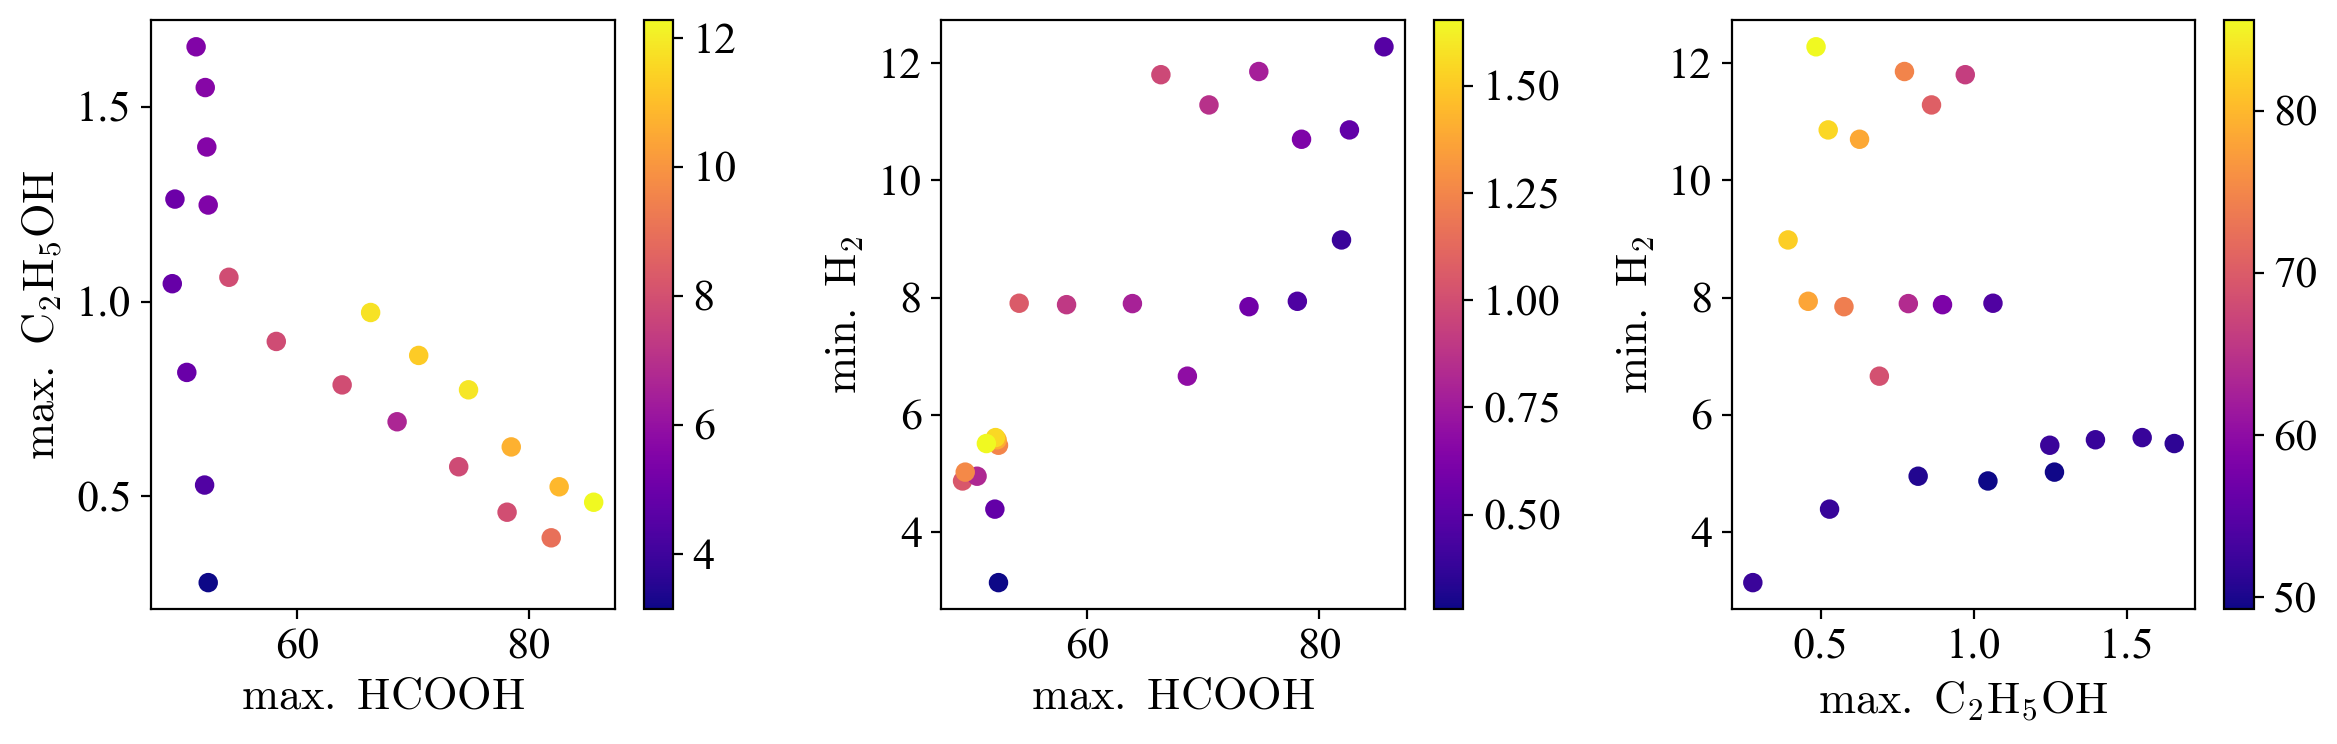

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# ax[0], x = max HCOOH, y = max C2H5OH, cbar = min H2
HCOOH = 100*(-1*res.F[:, 0])
C2H5OH = 100*(-1*res.F[:, 1])
H2 = 100*(res.F[:, 2])

cbar0 = plt.colorbar(ax[0].scatter(HCOOH, C2H5OH, c=H2, cmap='plasma'))
ax[0].set_xlabel(r'$\rm max. \ HCOOH %$', fontsize=16)
ax[0].set_ylabel(r'$\rm max. \ C_2H_5OH %$', fontsize=16)

# ax[1], x = max HCOOH, y = min H2, cbar = max C2H5OH
cbar1 = plt.colorbar(ax[1].scatter(HCOOH, H2, c=C2H5OH, cmap='plasma'))
ax[1].set_xlabel(r'$\rm max. \ HCOOH %$', fontsize=16)
ax[1].set_ylabel(r'$\rm min. \ H_2 %$', fontsize=16)

# ax[2], x = max C2H5OH, y = min H2, cbar = max HCOOH
cbar2 = plt.colorbar(ax[2].scatter(C2H5OH, H2, c=HCOOH, cmap='plasma'))
ax[2].set_xlabel(r'$\rm max. \ C_2H_5OH %$', fontsize=16)
ax[2].set_ylabel(r'$\rm min. \ H_2 %$', fontsize=16)

plt.tight_layout()

Index(['Sn %', 'Pot', 'pH', 'cDen', 'HCOOH', 'C2H5OH', 'H2'], dtype='object')


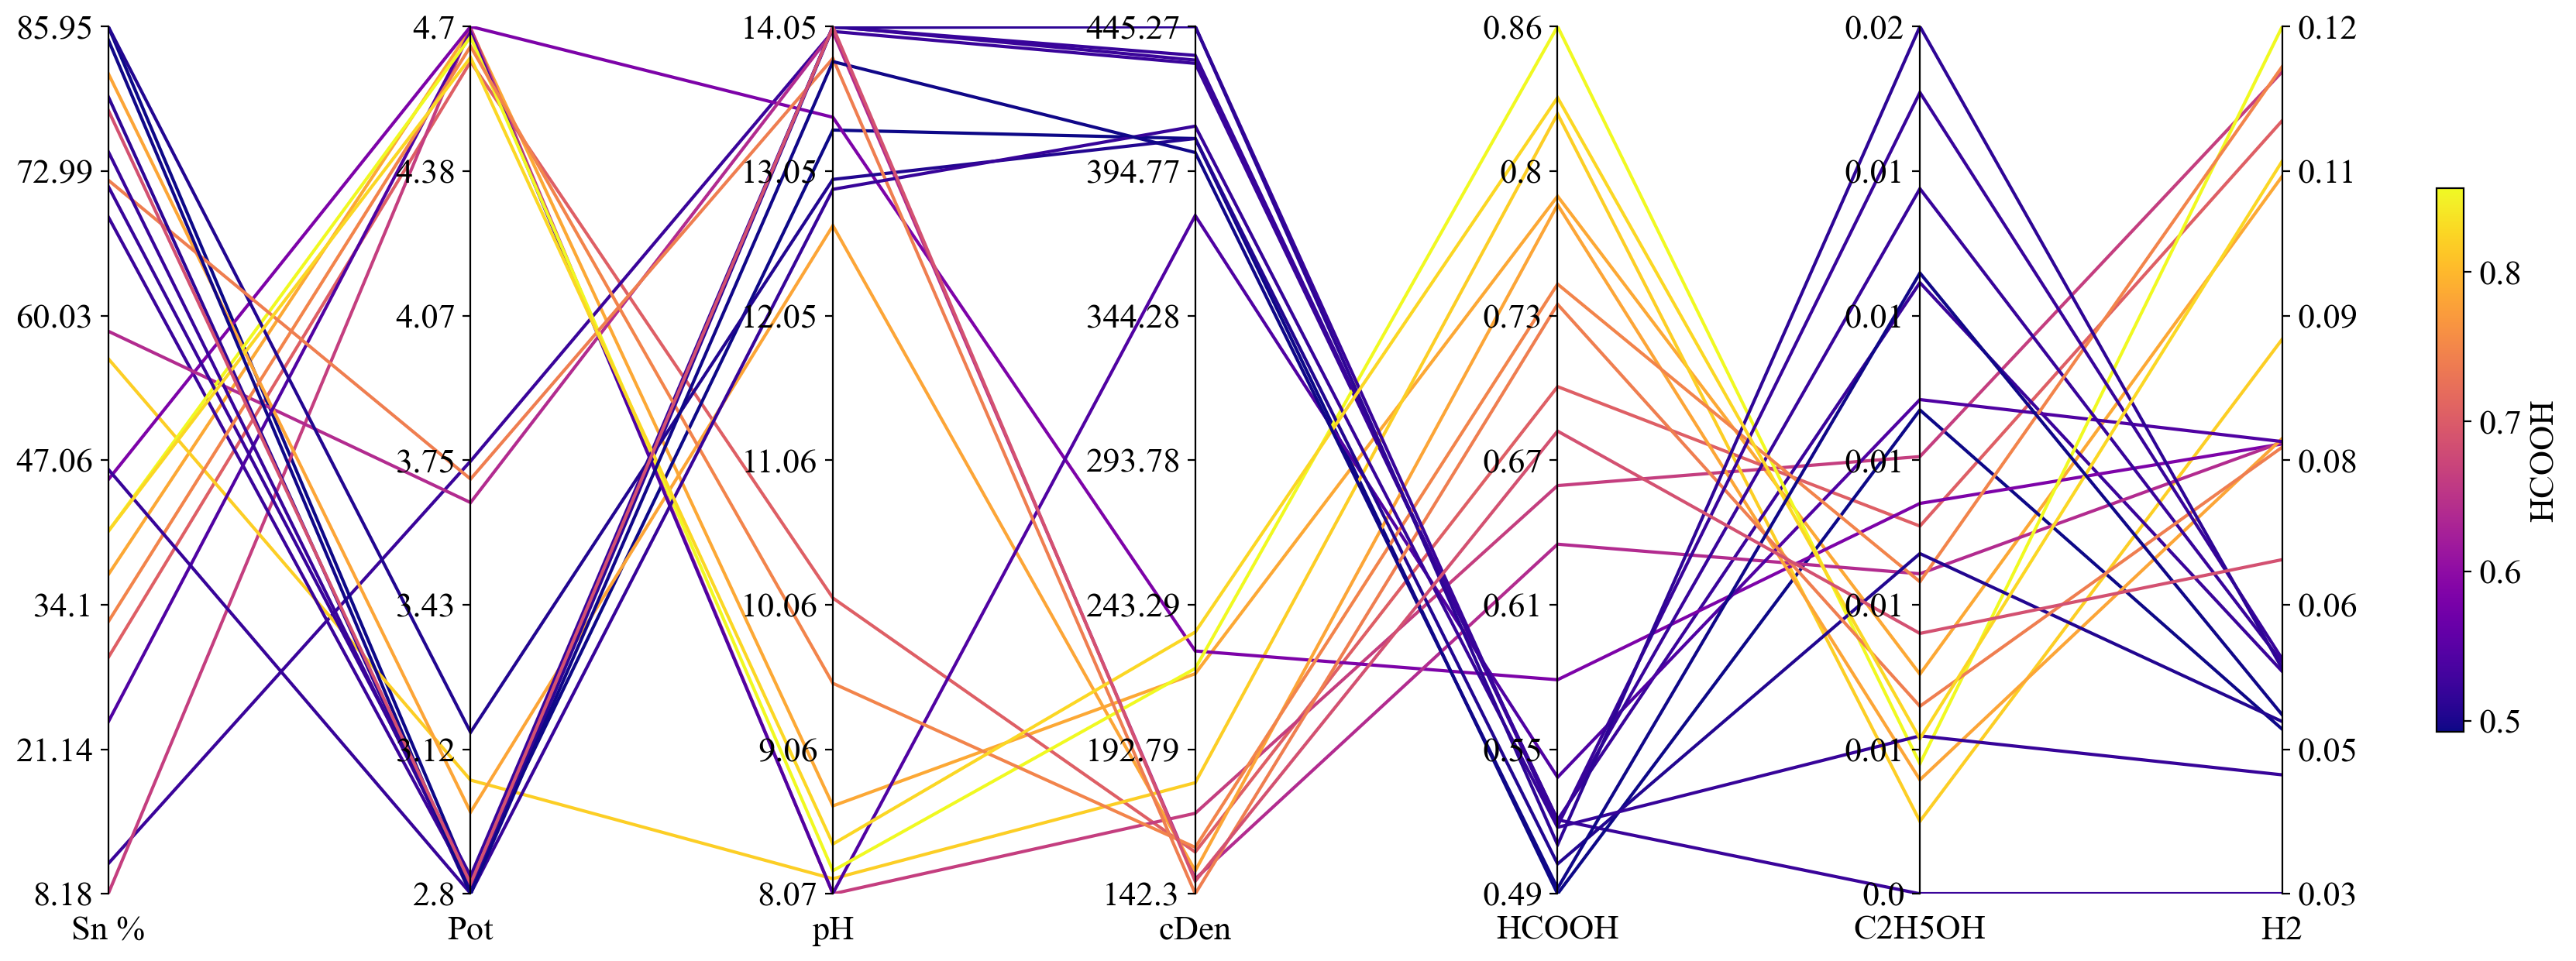

In [38]:
import paxplot as px

interest_columns = ['Sn %', 'Pot', 'pH', 'cDen']
dd = pd.DataFrame(res.X, columns=interest_columns)
dd['HCOOH'] = -res.F[:, 0]
dd['C2H5OH'] = -res.F[:, 1]
dd['H2'] = res.F[:, 2]

cols = dd.columns

print(cols)

# Create figure
paxfig = px.pax_parallel(n_axes=len(cols))
paxfig.plot(dd.to_numpy())

# Add labels
paxfig.set_labels(cols)

# Add colorbar
color_col = len(cols) - 3
paxfig.add_colorbar(ax_idx=color_col, cmap='plasma', colorbar_kwargs={'label': cols[color_col]})

# Set limits for each axis
lower_limit = {interest_columns[i]: data[interest_columns[i]].min() for i in range(len(interest_columns))}

upper_limit = {interest_columns[i]: data[interest_columns[i]].max() for i in range(len(interest_columns))}

# for idx, col in enumerate(cols):
#     paxfig.set_lim(ax_idx=idx, bottom=lower_limit[col], top=upper_limit[col]) 

# set figure size
paxfig.set_size_inches(19, 8)
paxfig.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=0.9)  # Padding

# set labels
# all_labels = [
#             r'$\rm VW$', r'$\rm FR$', r'$\rm CNaCl$', r'$\rm SSA$', 
#             r'$\rm PV$', r'$\rm Psave$', r'$\rm PVmicro$', r'$\rm ID/IG$', 
#             r'$\rm N\ content$', r'$\rm O\ content$', r'$\rm SAC$']

# all_units = [
#             r'$\rm V$', r'$\rm ml/min$', r'$\rm mg/l$', r'$\rm m^{2}/g$', 
#             r'$\rm cm^{3}/g$', r'$\rm cm^{3}/g$', r'$\rm cm^{3}/g$', r'$\rm unitless$', 
#             r'$\rm at.\%$', r'$\rm at.\%$',  r'$\rm mg/g$']

# labels = [f'{all_labels[i]}\n({all_units[i]})' for i in range(len(all_labels))]

# paxfig.set_labels(labels)

plt.show()